In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from mlp.data_providers import CIFAR10DataProvider,CIFAR100DataProvider
%matplotlib inline

In [2]:
train_data = CIFAR100DataProvider('train',batch_size=50)
valid_data = CIFAR100DataProvider('valid',batch_size=50)

(-0.5, 31.5, 31.5, -0.5)

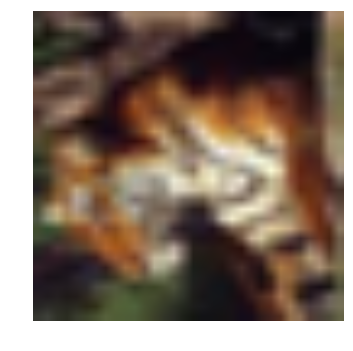

In [4]:
get_images = train_data.next()[0]
image = get_images[11].reshape((32,32,3),order='F')
plt.imshow(image)
plt.axis('off')

In [5]:
def plot_graph(err_train,acc_train,err_valid,acc_valid,name="Graph"):
    path='./graphs_100/'+name
    val_epoch=range(5,105,5)
    err_epoch=range(1,101,1)
    plt.grid()
    plt.plot(err_epoch,err_train,'-b+',label='Train Error')
    plt.plot(val_epoch,err_valid,'-ro',label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.savefig(path+'_error.png')
    #plt.show()
    plt.close()
    plt.grid()
    plt.plot(err_epoch,acc_train,'-b+',label='Train Accuracy')
    plt.plot(val_epoch,acc_valid,'-ro',label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    plt.savefig(path+'_accuracy.png')
    #plt.show()
    plt.close()    

In [6]:
#Experiments all epoch 60. batch size 100. Layer size =3

#3. Optimization function
#Adam, Adagrad, Gradient descent=0.3,gradient descent =0.03
err_adam_train = []
err_adam_valid = []
err_adagrad_train = []
err_adagrad_valid = []
err_gd03_train = []
err_gd003_valid = []

acc_adam_train = []
acc_adam_valid = []
acc_adagrad_train = []
acc_adagrad_valid = []
acc_gd03_train = []
acc_gd003_valid = []

In [7]:
graph_adamlayer = tf.Graph()
graph_adagradlayer= tf.Graph()
graph_gd03layer= tf.Graph()
graph_gd003layer= tf.Graph()

In [8]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

In [9]:
def run_graph(custom_graph=None):
    num_epochs=100
    err_train=[]
    err_valid=[]
    acc_train=[]
    acc_valid=[]
    tf.reset_default_graph()
    if custom_graph=="None":
        print "ERROR: Computation Graph not found"
    with tf.Session(graph=custom_graph) as sess:
        sess.run(init)
        for e in range(num_epochs):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            err_train.append(running_error)
            acc_train.append(running_accuracy)
            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                  .format(e + 1, running_error, running_accuracy))
            if (e + 1) % 5 == 0:
                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                err_valid.append(valid_error)
                acc_valid.append(valid_accuracy)
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                       .format(valid_error, valid_accuracy))
        return err_train,acc_train,err_valid,acc_valid


## Begin Different Optimizers

In [10]:
#Adam
with graph_adamlayer.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
    with tf.name_scope('fc-layer-3'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)
    
    init = tf.global_variables_initializer()

start = time.time()
err_adam_train,acc_adam_train,err_adam_valid,acc_adam_valid = run_graph(graph_adamlayer)
print("Time taken: %f"%(time.time()-start))

End of epoch 01: err(train)=4.13 acc(train)=0.07
End of epoch 02: err(train)=3.73 acc(train)=0.13
End of epoch 03: err(train)=3.58 acc(train)=0.15
End of epoch 04: err(train)=3.46 acc(train)=0.17
End of epoch 05: err(train)=3.37 acc(train)=0.19
                 err(valid)=3.44 acc(valid)=0.19
End of epoch 06: err(train)=3.30 acc(train)=0.20
End of epoch 07: err(train)=3.24 acc(train)=0.21
End of epoch 08: err(train)=3.17 acc(train)=0.22
End of epoch 09: err(train)=3.12 acc(train)=0.23
End of epoch 10: err(train)=3.06 acc(train)=0.24
                 err(valid)=3.36 acc(valid)=0.20
End of epoch 11: err(train)=3.01 acc(train)=0.25
End of epoch 12: err(train)=2.97 acc(train)=0.26
End of epoch 13: err(train)=2.93 acc(train)=0.26
End of epoch 14: err(train)=2.89 acc(train)=0.27
End of epoch 15: err(train)=2.85 acc(train)=0.28
                 err(valid)=3.40 acc(valid)=0.21
End of epoch 16: err(train)=2.81 acc(train)=0.29
End of epoch 17: err(train)=2.77 acc(train)=0.30
End of epoch 18: err

In [11]:
#Gradient Descent 0.3
with graph_gd03layer.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
    with tf.name_scope('fc-layer-3'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)
    init = tf.global_variables_initializer()

start = time.time()
err_gd03_train,acc_gd03_train,err_gd03_valid,acc_gd03_valid = run_graph(graph_gd03layer)
print("Time taken: %f"%(time.time()-start))
    

End of epoch 01: err(train)=4.22 acc(train)=0.05
End of epoch 02: err(train)=3.88 acc(train)=0.09
End of epoch 03: err(train)=3.76 acc(train)=0.11
End of epoch 04: err(train)=3.68 acc(train)=0.13
End of epoch 05: err(train)=3.61 acc(train)=0.14
                 err(valid)=3.63 acc(valid)=0.14
End of epoch 06: err(train)=3.55 acc(train)=0.15
End of epoch 07: err(train)=3.51 acc(train)=0.16
End of epoch 08: err(train)=3.47 acc(train)=0.16
End of epoch 09: err(train)=3.44 acc(train)=0.17
End of epoch 10: err(train)=3.40 acc(train)=0.17
                 err(valid)=3.52 acc(valid)=0.16
End of epoch 11: err(train)=3.36 acc(train)=0.18
End of epoch 12: err(train)=3.34 acc(train)=0.18
End of epoch 13: err(train)=3.32 acc(train)=0.19
End of epoch 14: err(train)=3.27 acc(train)=0.20
End of epoch 15: err(train)=3.25 acc(train)=0.20
                 err(valid)=3.49 acc(valid)=0.18
End of epoch 16: err(train)=3.23 acc(train)=0.20
End of epoch 17: err(train)=3.20 acc(train)=0.21
End of epoch 18: err

In [10]:
#Gradient Descent 0.03
with graph_gd003layer.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
    with tf.name_scope('fc-layer-3'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer().minimize(error)
    
    init = tf.global_variables_initializer()

start = time.time()
err_gd003_train,acc_gd003_train,err_gd003_valid,acc_gd003_valid = run_graph(graph_gd003layer)
print("Time taken: %f"%(time.time()-start))
    

End of epoch 01: err(train)=1.89 acc(train)=0.32
End of epoch 02: err(train)=1.70 acc(train)=0.39
End of epoch 03: err(train)=1.62 acc(train)=0.42
End of epoch 04: err(train)=1.56 acc(train)=0.44
End of epoch 05: err(train)=1.52 acc(train)=0.45
                 err(valid)=1.61 acc(valid)=0.43
End of epoch 06: err(train)=1.48 acc(train)=0.47
End of epoch 07: err(train)=1.46 acc(train)=0.48
End of epoch 08: err(train)=1.43 acc(train)=0.49
End of epoch 09: err(train)=1.41 acc(train)=0.49
End of epoch 10: err(train)=1.38 acc(train)=0.50
                 err(valid)=1.50 acc(valid)=0.48
End of epoch 11: err(train)=1.36 acc(train)=0.51
End of epoch 12: err(train)=1.34 acc(train)=0.52
End of epoch 13: err(train)=1.32 acc(train)=0.53
End of epoch 14: err(train)=1.30 acc(train)=0.54
End of epoch 15: err(train)=1.28 acc(train)=0.54
                 err(valid)=1.48 acc(valid)=0.48
End of epoch 16: err(train)=1.26 acc(train)=0.55
End of epoch 17: err(train)=1.24 acc(train)=0.55
End of epoch 18: err

In [ ]:
print err_adam_train

In [17]:
#Adagrad
with graph_adagradlayer.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        num_hidden = 200
    with tf.name_scope('fc-layer-3'):
        hidden_1 = fully_connected_layer(inputs, train_data.inputs.shape[1], num_hidden)
        hidden_2 = fully_connected_layer(hidden_1, num_hidden, num_hidden)
        hidden_3 = fully_connected_layer(hidden_2, num_hidden, num_hidden)
    with tf.name_scope('output-layer'):
        outputs = fully_connected_layer(hidden_3, num_hidden, train_data.num_classes, tf.identity)

    with tf.name_scope('error'):
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))

    with tf.name_scope('train'):
        train_step = tf.train.AdagradOptimizer(learning_rate=0.01).minimize(error)
    
    init = tf.global_variables_initializer()
    
start = time.time()
err_adagrad_train,acc_adagrad_train,err_adagrad_valid,acc_adagrad_valid = run_graph(graph_adagradlayer)
print("Time taken: %f"%(time.time()-start))

End of epoch 01: err(train)=1.91 acc(train)=0.31
End of epoch 02: err(train)=1.70 acc(train)=0.39
End of epoch 03: err(train)=1.61 acc(train)=0.43
End of epoch 04: err(train)=1.55 acc(train)=0.45
End of epoch 05: err(train)=1.50 acc(train)=0.47
                 err(valid)=1.53 acc(valid)=0.46
End of epoch 06: err(train)=1.46 acc(train)=0.48
End of epoch 07: err(train)=1.43 acc(train)=0.49
End of epoch 08: err(train)=1.40 acc(train)=0.50
End of epoch 09: err(train)=1.37 acc(train)=0.51
End of epoch 10: err(train)=1.35 acc(train)=0.52
                 err(valid)=1.45 acc(valid)=0.49
End of epoch 11: err(train)=1.33 acc(train)=0.53
End of epoch 12: err(train)=1.30 acc(train)=0.54
End of epoch 13: err(train)=1.28 acc(train)=0.55
End of epoch 14: err(train)=1.26 acc(train)=0.55
End of epoch 15: err(train)=1.24 acc(train)=0.56
                 err(valid)=1.41 acc(valid)=0.51
End of epoch 16: err(train)=1.22 acc(train)=0.57
End of epoch 17: err(train)=1.21 acc(train)=0.58
End of epoch 18: err

In [19]:
f = open('./log/Optimizers.csv', 'w' )
f.write( 'Optimizer,'+'err_train,'+'acc_train,'+'err_valid,'+'acc_valid'+'\n'+
        'adam,'+
repr(err_adam_train)+','+
repr(acc_adam_train)+','+
repr(err_adam_valid)+','+
repr(acc_adam_valid)+'\n'+
'adagrad,'+
repr(err_adagrad_train)+','+
repr(acc_adagrad_train)+','+
repr(err_adagrad_valid)+','+
repr(acc_adagrad_valid)+'\n'+
    'gd03,'+    
repr(err_gd03_train)+','+
repr(acc_gd03_train)+','+
repr(err_gd03_valid)+','+
repr(acc_gd03_valid)+'\n'+
'gd003,'+
repr(err_gd003_train)+','+
repr(acc_gd003_train)+','+
repr(err_gd003_valid)+','+
repr(acc_gd003_valid)+'\n')
f.close()

In [12]:
plot_graph(err_adam_train,acc_adam_train,err_adam_valid,acc_adam_valid,'Optimizers_adam')
#plot_graph(err_adagrad_train,acc_adagrad_train,err_adagrad_valid,acc_adagrad_valid,'Optimizers_adagrad')
plot_graph(err_gd03_train,acc_gd03_train,err_gd03_valid,acc_gd03_valid,'Optimizers_gd03')
#plot_graph(err_gd003_train,acc_gd003_train,err_gd003_valid,acc_gd003_valid,'Optimizers_gd003')
#plot_graph(err_500_train,acc_500_train,err_500_valid,acc_500_valid,'Optimizers_500')

In [13]:
print "Success"

Success


## End of Layer variation experiment